## Import

In [12]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from model import (
    load_features,
    train_garch,
    forecast_garch,
    evaluate_models
)
from config import TEST_SIZE, RESULTS_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [4]:
df = load_features()
df = df.drop(['sentiment', 'sentiment_lag1', 'sentiment_scaled'], axis=1)
returns = df["log_return"]
target = df["target_volatility"]
df


,Close,High,Low,Open,Volume,log_return,volatility_20d,abs_return,return_squared,lag_1,lag_5,lag_10,lag_20,rolling_abs_return_mean_20d,target_volatility
date,,,,,,,,,,,,,,,
1993-03-02,24.793131,24.793131,24.413820,24.448303,182400,0.014711,0.132770,0.014711,2.164002e-04,-0.002818,-0.000715,-0.025551,0.007087,0.005358,0.109394
1993-03-03,24.896578,24.913819,24.793129,24.827612,280100,0.004164,0.133243,0.004164,1.733660e-05,0.014711,0.012794,-0.000719,0.002116,0.005460,0.108620
1993-03-04,24.758650,24.931064,24.758650,24.931064,89500,-0.005555,0.129990,0.005555,3.086293e-05,0.004164,0.002116,-0.000720,0.010516,0.005212,0.107371
1993-03-05,24.689684,24.896581,24.672443,24.793132,40000,-0.002789,0.129422,0.002789,7.780835e-06,-0.005555,0.001408,0.003593,0.004175,0.005143,0.131427
1993-03-08,25.241415,25.241415,24.741414,24.741414,50800,0.022101,0.151808,0.022101,4.884364e-04,-0.002789,-0.002818,0.003580,-0.000696,0.006213,0.103419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-16,691.659973,694.250000,690.099976,693.659973,79289200,-0.000838,0.072942,0.000838,7.026390e-07,0.002720,0.006592,0.001831,-0.011065,0.003977,NaN
2026-01-20,677.580017,684.770020,676.570007,681.489990,111623300,-0.020567,0.104281,0.020567,4.229939e-04,-0.000838,0.001569,0.006638,0.007523,0.004629,NaN
2026-01-21,685.400024,688.739990,678.130005,679.650024,127844500,0.011475,0.107342,0.011475,1.316755e-04,-0.020567,-0.002001,0.005930,0.009023,0.004752,NaN


## Chronological split

In [5]:
split_idx = int(len(df) * (1 - TEST_SIZE))

returns_train = returns.iloc[:split_idx]
returns_test = returns.iloc[split_idx:]
target_test = target.iloc[split_idx:]


## Rolling 1 step GARCH

In [6]:
garch_preds = []

for t in range(len(returns_test)):
    model = train_garch(returns.iloc[:split_idx + t])
    pred = forecast_garch(model, horizon=1)
    garch_preds.append(pred)


## Evaluate

In [ ]:
## Evaluate (Using the Filtering Method)

# 1. Convert preds to a Series so we can align it with the index
# Note: Using garch_preds here to match your GARCH notebook
preds_series = pd.Series(garch_preds, index=target_test.index)

# 2. Filter out the NaNs from the ground truth (the last 20 days)
# This keeps only the rows where we have an actual target to compare against
valid_mask = ~target_test.isna()

y_true_filtered = target_test[valid_mask].values
y_pred_filtered = preds_series[valid_mask].values

# 3. Run the evaluation on the CLEAN data
metrics = evaluate_models(
    y_true=y_true_filtered,
    y_pred=y_pred_filtered,
    model_name="GARCH"
)

print(f"\n GARCH Historical Performance :")
print(f"  RMSE: {metrics['rmse']:.4f}")
print(f"  MAE: {metrics['mae']:.4f}")
print(f"  R²: {metrics['R_squared']:.4f}")


 GARCH Performance:
 RMSE: 0.1080
 MAE: 0.0620
 R-squared: 0.1158

 GARCH Historical Performance (Excluding 2026 NaNs):
  RMSE: 0.1080
  MAE: 0.0620
  R²: 0.1158

 🚀 LIVE GARCH FORECAST for the next 20 days: 0.1424


## Save GARCH predictions

In [18]:
garch_preds_df = pd.DataFrame({
    "target_vol": target_test.values,
    "garch_pred": garch_preds,
}, index=target_test.index)
garch_preds_df.to_csv(RESULTS_DIR / "preds" / "garch_preds.csv", index=True)
print(f" Predictions saved to {RESULTS_DIR / 'preds' / 'garch_preds.csv'}")

 Predictions saved to C:\Users\hp\Financial-volatility-forecasting\results\preds\garch_preds.csv


## GARCH: Forecast vs Target Volatility

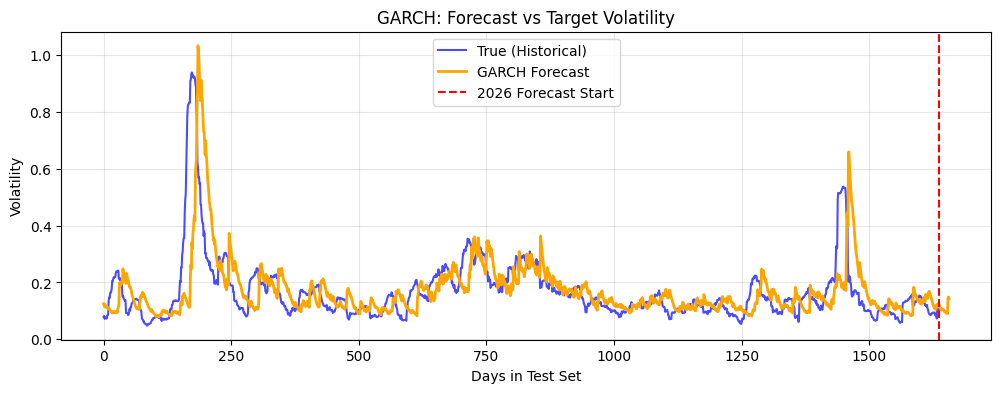

In [19]:
plt.figure(figsize=(12, 4))

# 1. Plot True Volatility (only the historical part, hide the 2026 NaNs)
mask = ~target_test.isna()
plt.plot(target_test[mask].values, label="True (Historical)", alpha=0.7, color='blue')

# 2. Plot GARCH Predictions (Full range, including the 2026 forecast)
# Converting to numpy array to ensure plotting works correctly with the true values
plt.plot(np.array(garch_preds), label="GARCH Forecast", color='orange', linewidth=2)

# 3. Add the vertical line where the "Future" begins
# This is usually len(target_test) - 20
plt.axvline(x=len(target_test[mask]), color='red', linestyle='--', label='2026 Forecast Start')

plt.title("GARCH: Forecast vs Target Volatility")
plt.xlabel("Days in Test Set")
plt.ylabel("Volatility")
plt.legend()
plt.grid(alpha=0.3)

# Save to the garch folder
plt.savefig(f"{RESULTS_DIR}/figures/garch/GARCH_predicted_vs_True_Volatility.png", dpi=300, bbox_inches="tight")

## Save Metric

In [20]:
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(RESULTS_DIR / "metrics" / "garch_metrics.csv", index=False)
print(f"\n Metrics saved to {RESULTS_DIR / 'metrics' / 'garch_metrics.csv'}")


 Metrics saved to C:\Users\hp\Financial-volatility-forecasting\results\metrics\garch_metrics.csv
